In [7]:
import time 
start = time.time()

import fastf1
import fastf1.plotting
import fastf1.api

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os  
from datetime import timedelta
import csv
import seaborn as sns
from fastf1.ergast import Ergast

year = 2025
race_number = 13
race_session = 'Q'
Lap_Number = 44
team = 'Ferrari'

session= fastf1.get_session(year, race_number, race_session)
session.load()

teams = fastf1.plotting.list_team_names(session)
team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
event_name = session.event.EventName

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '1', '23', '63', '22', '6', '30', '5', '31', '87', '10', '27', '55', '44', '43', '12', '14', '18']
req            INFO 	Using cached data for driver_info


In [8]:
def highlight(s, min_max):
    if min_max == 'min':
        is_min_max = s == s.min()
    if min_max == 'max':
        is_min_max = s == s.max()

    return ['color: green' if v else 'color: orange' for v in is_min_max]

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

def background_color_df(s):
    colors= []
    for time_and_compound in s:
        if 'SOFT' in time_and_compound:
            colors.append('background-color:red')
        elif 'MEDIUM' in time_and_compound:
            colors.append('background-color:yellow')
        elif 'HARD' in time_and_compound:
            colors.append('background-color:white')
        elif 'INTERMEDIATE' in time_and_compound:
            colors.append('background-color:green')
        elif 'WET' in time_and_compound:
            colors.append('background-color:blue')
        elif ' SUPERSOFT' in time_and_compound:
            colors.append('background-color:purple')
        elif ' ULTRASOFT' in time_and_compound:
            colors.append('background-color:orangered')
        elif ' HYPERSOFT' in time_and_compound:
            colors.append('background-color:pink')
        elif ' SUPERHARD' in time_and_compound:
            colors.append('background-color:orange')
        else:
            colors.append('background-color:grey')
    return colors


def style_lap_df(df, session, Lap_Number):
    df['Tyre'] = df.Tyre.replace(to_replace = tyres)
    df.index = range(1, len(df) + 1)
    
    style_df = df.style
    style_df = style_df.apply(highlight_driver, subset=['Driver'], session = session)
    style_df = style_df.apply(is_personal_best, subset=['Sector1'], column='Sector1Time', extreme='min', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['Sector2'], column='Sector2Time', extreme='min', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['Sector3'], column='Sector3Time', extreme='min', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['LapTime'], column='LapTime', extreme='min', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['I1'], column='SpeedI1', extreme='max', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['I2'], column='SpeedI2', extreme='max', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['FL'], column='SpeedFL', extreme='max', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(is_personal_best, subset=['ST'], column='SpeedST', extreme='max', session = session, Lap_Number = Lap_Number)
    style_df = style_df.apply(color_df, subset=['Gap_ahead_Driver'], color='orange')
    style_df = style_df.apply(color_df, subset=['Gap_to_Leader'], color='orange')

    return style_df.format({
        'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'No Data',
        'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'I1': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'I2': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'No Data',
        'FL': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'No Data',
        'ST': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Lap': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'PitStop': lambda x: int(x) if pd.notnull(x) else 'No Data',
        'Gap_ahead_Driver': lambda x: str(abs(x))[7:-3] if pd.notnull(x) else 'No Data',
        'Gap_to_Leader': lambda x: str(abs(x))[7:-3] if pd.notnull(x) else 'No Data',
    })

def fastest_per_driver(s, driver_fastest_lap):
    colors = []
    for time in s:
        if time.split(' ')[0] == overall_fastest:
            colors.append('color:purple')
        elif time.split(' ')[0] == driver_fastest_lap:
            colors.append('color:darkgreen')
        else:
            colors.append('color:black')
    return colors

def highlight_driver(s):
    drivers = []
    for driver_name in s:
        driver_color = fastf1.plotting.get_driver_color(driver_name[0:3], session)
        drivers.append(f'color: {driver_color}')
    return drivers

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

def is_personal_best(subset, column, extreme ,session, Lap_Number):
    best_colors = []
    extreme_values = {}
    driver_ids = list(session.drivers)

    for driver_id in driver_ids:
        if extreme == 'min':
            extreme_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].min()
        elif extreme == 'max':
            extreme_values[driver_id] = session.laps.pick_drivers(driver_id).pick_laps(range(0, Lap_Number + 1))[column].max()

    all_driver_laps = session.laps.pick_drivers(session.drivers).pick_laps(range(0, Lap_Number + 1))
    if not all_driver_laps.empty:
        if extreme == 'min':
            overall_extreme = all_driver_laps[column].min()
        elif extreme == 'max':
            overall_extreme = all_driver_laps[column].max()
    else:
        if extreme == 'min':
            overall_extreme = 'inf'
        elif extreme == 'max':
            overall_extreme = 0

    for column_value in subset:
        color = 'color:orange'
        for driver in session.drivers:
            if column_value  == overall_extreme:
                color = 'color:purple'
            if column_value == extreme_values.get(driver):
                color = 'color:green'

        best_colors.append(color)

    return best_colors



def flag_color_row(s):
    flag_colors=[]
    for flag_color in s:
        match flag_color:
            case flag_color if 'GREEN' in flag_color:
                flag_colors.append('color:green')
            case flag_color if 'YELLOW' in flag_color:
                flag_colors.append('color:yellow')
            case flag_color if 'DOUBLE YELLOW' in flag_color:
                flag_colors.append('color:orange')
            case flag_color if 'RED' in flag_color:
                flag_colors.append('color:red')
            case flag_color if 'BLUE' in flag_color:
                flag_colors.append('color:blue')
            case flag_color if 'CLEAR' in flag_color:
                flag_colors.append('color:white')
            case flag_color if 'BLACK' in flag_color:
                flag_colors.append('color:dark-grey')
            case _:
                flag_colors.append('color:grey')
    return flag_colors

def get_wind_direction_cat(WindDirection):
    normalized_direction = WindDirection % 360
    if normalized_direction < 0:
        normalized_direction += 360
    match normalized_direction:
        case _ if (normalized_direction >= 348.75 or normalized_direction < 11.25):
            return 'N'
        case _ if (normalized_direction >= 11.25 and normalized_direction < 33.75):
            return 'NNE'
        case _ if (normalized_direction >= 33.75 and normalized_direction < 56.25):
            return 'NE'
        case _ if (normalized_direction >= 56.25 and normalized_direction < 78.75):
            return 'ENE'
        case _ if (normalized_direction >= 78.75 and normalized_direction < 101.25):
            return 'E'
        case _ if (normalized_direction >= 101.25 and normalized_direction < 123.75):
            return 'ESE'
        case _ if (normalized_direction >= 123.75 and normalized_direction < 146.25):
            return 'SE'
        case _ if (normalized_direction >= 146.25 and normalized_direction < 168.75):
            return 'SSE'
        case _ if (normalized_direction >= 168.75 and normalized_direction < 191.25):
            return 'S'
        case _ if (normalized_direction >= 191.25 and normalized_direction < 213.75):
            return 'SSW'
        case _ if (normalized_direction >= 213.75 and normalized_direction < 236.25):
            return 'SW'
        case _ if (normalized_direction >= 236.25 and normalized_direction < 258.75):
            return 'WSW'
        case _ if (normalized_direction >= 258.75 and normalized_direction < 281.25):
            return 'W'
        case _ if (normalized_direction >= 281.25 and normalized_direction < 303.75):
            return 'WNW'
        case _ if (normalized_direction >= 303.75 and normalized_direction < 326.25):
            return 'NW'
        case _ if (normalized_direction >= 326.25 and normalized_direction < 348.75):
            return 'NNW'
        case _:
            return 'Invalid'

def highlight_driver(subset, session):
    drivers = []
    for driver_name in subset:
        driver_color = fastf1.plotting.get_driver_color(driver_name[0:3], session)
        drivers.append(f'color: {driver_color}')
    return drivers

def color_df(s, color):
    colors= []
    for driver_name in s:
        colors.append(f'color:{color}')
    return colors

tyres={
    'SOFT':'🔴',
    'MEDIUM':'🟡',
    'HARD':'⚪',
    'INTERMEDIATE':'🟢',
    'WET':'🔵',
    'SUPERSOFT': '🟣',
    'ULTRASOFT': '🟠',
    'HYPERSOFT': '🩷',
    'SUPERHARD': '🍊',
}

In [9]:
if race_session == 'Q':
    q1, q2, q3 = session.laps.split_qualifying_sessions()
            
    is_nat = np.isnat(q1['LapTime'])
    q1 = q1[~is_nat]
    is_nat = np.isnat(q2['LapTime'])
    q2 = q2[~is_nat]
    is_nat = np.isnat(q3['LapTime'])
    q3 = q3[~is_nat]

def get_lap_and_tyre(session, session_laps, Lap_Number):
    driver_data_all_laps = []
    if Lap_Number<10:
        lap_range =range(0, Lap_Number+1)
    else :
        lap_range = range(Lap_Number-9, Lap_Number+1)
    for lap in lap_range:

        LapTimePerLap = []
        driver_list = []
        #print(session_laps.DriverNumber.unique())
        for driver in session.drivers:
            
            try:
                driver_lap = session_laps.pick_laps(lap).pick_drivers(driver)
                driver_data = str(driver_lap.LapTime.iloc[0]).split(' ')[2]  + ' ' + str(driver_lap.Compound.iloc[0]) + ' ' + str(driver_lap.PitInTime.iloc[0]) + ' '  + str(driver_lap.PitOutTime.iloc[0])
            except:
                continue
            if driver_data.split(' ')[0] == 'NaT':
                driver_data = 'Ø No-data'
            if driver_data != 'Ø No-data':
                if driver_data.split(' ')[2] != 'NaT':
                    driver_data = driver_data.split(' ')[1] + ' ' + 'PIT-IN'
                elif driver_data.split(' ')[3] != 'NaT':
                    driver_data = driver_data.split(' ')[1] + ' ' + 'OUT'
           
            driver_list.append(driver)
            LapTimePerLap.append(driver_data)   
            
        LapTimePerLapSeries = pd.Series(LapTimePerLap, index=driver_list)
        driver_data_all_laps.append(LapTimePerLapSeries)
    driver_data_all_laps_df = pd.DataFrame(driver_data_all_laps)
    driver_data_all_laps_df = driver_data_all_laps_df.fillna('Ø No-data')
    if Lap_Number > 10 :
        driver_data_all_laps_df.index = range(Lap_Number-9, Lap_Number+1)
    else:
        driver_data_all_laps_df.index = range(1, Lap_Number+2)
    styled_df = driver_data_all_laps_df.style

    styled_df.set_properties(**{'color': 'black'})

    styled_df = styled_df.apply(background_color_df)
    formatters = {}
    #print(driver_list)
    for driver in session_laps.DriverNumber.unique():
        formatters[driver] = lambda x: (
            str(x)[4:12]
            if len(str(x).split(' ')) >= 4
            else x.split(' ')[1]
        )

    final_formatters = {k: v for k, v in formatters.items() if k in driver_data_all_laps_df.columns}
    styled_df = styled_df.format(final_formatters)
    return styled_df
 
Lap_Number =  int(max(q2.LapNumber))
get_lap_and_tyre(session, q2, Lap_Number)

,1,63,22,5,16,6,55,4,23,30,31,87,10,27,81
6,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data
7,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data
8,1:40.951,1:41.379,1:41.245,1:41.973,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data
9,No-data,PIT-IN,PIT-IN,PIT-IN,1:41.084,1:41.562,1:42.029,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data
10,No-data,No-data,No-data,No-data,PIT-IN,PIT-IN,PIT-IN,1:40.715,1:41.505,1:41.753,1:41.675,PIT-IN,1:42.001,1:41.955,No-data
11,No-data,1:41.254,PIT-IN,1:41.336,No-data,No-data,No-data,PIT-IN,No-data,PIT-IN,PIT-IN,No-data,PIT-IN,PIT-IN,1:40.626
12,No-data,PIT-IN,No-data,PIT-IN,PIT-IN,1:41.281,1:41.758,No-data,No-data,No-data,No-data,1:41.617,No-data,No-data,PIT-IN
13,No-data,No-data,No-data,No-data,No-data,PIT-IN,PIT-IN,1:41.078,1:41.559,1:41.297,1:41.525,PIT-IN,1:41.633,1:41.707,No-data
14,No-data,No-data,No-data,No-data,No-data,No-data,No-data,PIT-IN,PIT-IN,PIT-IN,No-data,No-data,PIT-IN,PIT-IN,1:41.362
15,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,No-data,PIT-IN


In [84]:
if race_session == 'Q':
    q1, q2, q3 = session.laps.split_qualifying_sessions()
            
    is_nat = np.isnat(q1['LapTime'])
    q1 = q1[~is_nat]
    is_nat = np.isnat(q2['LapTime'])
    q2 = q2[~is_nat]
    is_nat = np.isnat(q3['LapTime'])
    q3 = q3[~is_nat]

def get_lap_and_tyre(session, session_laps, Lap_Number):
    driver_data_all_laps = []
    if Lap_Number<10:
        lap_range =range(0, Lap_Number+1)
    else :
        lap_range = range(Lap_Number-9, Lap_Number+1)
    for lap in lap_range:
        LapTimePerLap = []
        driver_list = []
        for driver in session.drivers:
            try:
                driver_lap = session_laps.pick_drivers(driver).pick_laps(range(0, Lap_Number + 1))
                driver_data = str(driver_lap.LapTime.iloc[lap]).split(' ')[2]  + ' ' + str(driver_lap.Compound.iloc[lap]) + ' ' + str(driver_lap.PitInTime.iloc[lap]) + ' '  + str(driver_lap.PitOutTime.iloc[lap])
                
                if driver_data.split(' ')[0] == 'NaT':
                    driver_data = 'Ø No-data'
                if driver_data != 'Ø No-data':
                    if driver_data.split(' ')[2] != 'NaT':
                        driver_data = driver_data.split(' ')[1] + ' ' + 'PIT-IN'
                    elif driver_data.split(' ')[3] != 'NaT':
                        driver_data = driver_data.split(' ')[1] + ' ' + 'OUT'
                driver_list.append(driver_lap.Driver.iloc[0] + ' ❚ '+ driver)
                LapTimePerLap.append(driver_data)
            except:
                continue
            
        
        LapTimePerLapSeries = pd.Series(LapTimePerLap, index=driver_list)
        driver_data_all_laps.append(LapTimePerLapSeries)
    driver_data_all_laps_df = pd.DataFrame(driver_data_all_laps)
    driver_data_all_laps_df = driver_data_all_laps_df.fillna('Ø No-data')
    if Lap_Number > 10 :
        driver_data_all_laps_df.index = range(Lap_Number-9, Lap_Number+1)
    else:
        driver_data_all_laps_df.index = range(1, Lap_Number+2)
    styled_df = driver_data_all_laps_df.style

    styled_df.set_properties(**{'color': 'black'})

    styled_df = styled_df.apply(background_color_df)
    return styled_df
    header_styles = []
    for i, col in enumerate(driver_data_all_laps_df.columns):
        driver_short_name = col.split(' ')[0]
        try:
            driver_color = fastf1.plotting.get_driver_color(driver_short_name, session)
        except Exception: 
            driver_color = '#000000' 
        header_styles.append({
            'selector': f'th.col_heading.col{i}',
            'props': [('color', driver_color)]
        })

    styled_df = styled_df.set_table_styles(header_styles, overwrite=False)

    formatters = {}
    for driver in driver_list:
        formatters[driver] = lambda x: (
            str(x)[4:12]
            if len(str(x).split(' ')) >= 4
            else x.split(' ')[1]
        )

    final_formatters = {k: v for k, v in formatters.items() if k in driver_data_all_laps_df.columns}
    styled_df = styled_df.format(final_formatters)

    overall_fastest = np.min(driver_data_all_laps_df).split(' ')[0]
    for driver in driver_data_all_laps_df.columns:
        driver_lap = session_laps.pick_drivers(driver.split(' ')[0]).pick_laps(range(0, Lap_Number + 1))
        if str(np.min(driver_lap.LapTime)) != 'NaT':
            driver_fastest_lap = str(np.min(driver_lap.LapTime)).split(' ')[2]
        else:
            driver_fastest_lap = 0
        styled_df.apply(fastest_per_driver, subset= [f'{driver}'], overall_fastest=overall_fastest, driver_fastest_lap=driver_fastest_lap)

    header_styles = []
    for i, col in enumerate(driver_data_all_laps_df.columns):
        driver_short_name = col.split(' ')[0]
        try:
            driver_color = fastf1.plotting.get_driver_color(driver_short_name, session)
        except Exception: 
            driver_color = '#000000' 
        header_styles.append({
            'selector': f'th.col_heading.col{i}',
            'props': [('color', driver_color)]
        })
    styled_df = styled_df.set_table_styles(header_styles, overwrite=False)
    return styled_df
Lap_Number =  int(max(q1.LapNumber))
get_lap_and_tyre(session, q1, 9)

,PIA ❚ 81,NOR ❚ 4,LEC ❚ 16,VER ❚ 1,RUS ❚ 63,ALB ❚ 23,HAM ❚ 44,LAW ❚ 30,BOR ❚ 5,GAS ❚ 10,BEA ❚ 87,HUL ❚ 27,TSU ❚ 22,STR ❚ 18,OCO ❚ 31,ANT ❚ 12,ALO ❚ 14,SAI ❚ 55,COL ❚ 43,HAD ❚ 6
1,00:01:41.998000 SOFT NaT NaT,00:01:42.076000 SOFT NaT NaT,SOFT PIT-IN,00:01:42.066000 SOFT NaT NaT,00:01:42.564000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,00:01:42.851000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,00:01:42.381000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,00:01:42.732000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,MEDIUM PIT-IN,00:01:42.164000 SOFT NaT NaT
2,00:01:41.201000 SOFT NaT NaT,SOFT PIT-IN,00:01:41.635000 SOFT NaT NaT,SOFT PIT-IN,00:01:41.784000 SOFT NaT NaT,00:01:41.772000 SOFT NaT NaT,00:01:41.939000 SOFT NaT NaT,00:01:41.765000 SOFT NaT NaT,SOFT PIT-IN,00:01:42.136000 SOFT NaT NaT,00:01:41.906000 SOFT NaT NaT,00:01:42.192000 SOFT NaT NaT,00:01:41.840000 SOFT NaT NaT,SOFT OUT,00:01:42.479000 SOFT NaT NaT,SOFT PIT-IN,00:01:42.500000 SOFT NaT NaT,00:01:41.691000 SOFT NaT NaT,00:01:42.545000 SOFT NaT NaT,SOFT PIT-IN
3,00:02:12.855000 SOFT NaT NaT,00:01:41.010000 SOFT NaT NaT,SOFT PIT-IN,00:01:41.334000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,00:01:41.908000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,00:01:42.683000 SOFT NaT NaT,SOFT PIT-IN,00:01:42.139000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,00:01:42.022000 SOFT NaT NaT,00:01:41.572000 SOFT NaT NaT
4,00:02:25.727000 SOFT NaT NaT,00:02:23.697000 SOFT NaT NaT,SOFT PIT-IN,SOFT PIT-IN,Ø No-data,00:01:41.893000 SOFT NaT NaT,00:01:41.664000 SOFT NaT NaT,00:01:41.748000 SOFT NaT NaT,Ø No-data,00:01:41.800000 SOFT NaT NaT,00:01:41.617000 SOFT NaT NaT,00:01:41.844000 SOFT NaT NaT,Ø No-data,SOFT PIT-IN,00:01:41.884000 SOFT NaT NaT,Ø No-data,00:01:42.385000 SOFT NaT NaT,Ø No-data,SOFT PIT-IN,SOFT PIT-IN
5,00:01:41.393000 SOFT NaT NaT,SOFT PIT-IN,Ø No-data,Ø No-data,Ø No-data,SOFT PIT-IN,Ø No-data,SOFT PIT-IN,Ø No-data,SOFT PIT-IN,SOFT PIT-IN,SOFT PIT-IN,Ø No-data,00:01:42.502000 SOFT NaT NaT,SOFT PIT-IN,Ø No-data,SOFT PIT-IN,Ø No-data,Ø No-data,Ø No-data
6,SOFT PIT-IN,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,SOFT PIT-IN,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data
7,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data
8,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data
9,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data
10,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data,Ø No-data


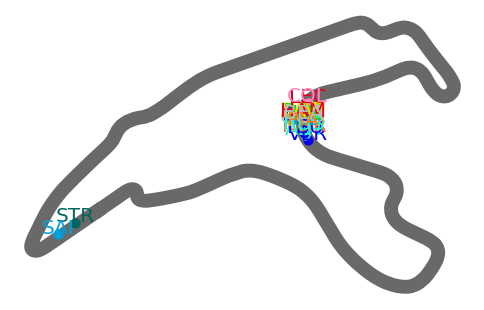

In [90]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

def get_map(session, laps, Lap_Number, minute):
    lap = laps.pick_fastest()
    pos = lap.get_pos_data()
    circuit_info = session.get_circuit_info()

    track = pos.loc[:, ('X', 'Y')].to_numpy()
    track_angle = circuit_info.rotation / 180 * np.pi

    rotated_track = rotate(track, angle=track_angle)

    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal', adjustable='box')

    ax.plot(rotated_track[:, 0], rotated_track[:, 1], linewidth=10, color='dimgrey')
    ax.tick_params(axis='x', which='both', bottom=False,
                    top=False, labelbottom=False)

    ax.tick_params(axis='y', which='both', right=False,
                    left=False, labelleft=False)
    
    if race_session == 'R' :
        each_lap = laps.pick_laps(range(0, Lap_Number))
        first_driver_session_time_in_microsec = int(str((each_lap.LapStartTime[each_lap.Position == 1 & (each_lap.LapNumber == max(each_lap.LapNumber))].values/1000)[0]).split(' ')[0])
    else:
        each_lap = laps

    for driver in session.drivers:
        if race_session == 'R' :
            each_lap = laps.pick_laps(range(0, Lap_Number+1)).pick_drivers(driver)
        else:
            each_lap = laps.pick_drivers(driver)
        try:
            each_lap_data = each_lap.get_pos_data()
            each_lap_pos_data = each_lap_data.loc[:, ('X', 'Y')].to_numpy()
            each_lap_rotated_data = rotate(each_lap_pos_data, angle=track_angle)
            each_lap_data.loc[:, 'X'] = each_lap_rotated_data[:, 0]
            each_lap_data.loc[:, 'Y'] = each_lap_rotated_data[:, 1]
            
            txt = each_lap.Driver.iloc[0]
        
            if race_session == 'R' :
                pos_x = (each_lap_data['X'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])
                pos_y = (each_lap_data['Y'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])
            else:
                pos_x = each_lap_data['X'][each_lap_data['SessionTime'] > timedelta(seconds=each_lap.Time.iloc[0].total_seconds() + (minute * 60))].iloc[0]
                pos_y = each_lap_data['Y'][each_lap_data['SessionTime'] > timedelta(seconds=each_lap.Time.iloc[0].total_seconds() + (minute * 60))].iloc[0]
            ax.scatter(pos_x, pos_y, color=fastf1.plotting.get_driver_color(txt, session=session), s=40, zorder=2)
            ax.text(pos_x, pos_y+400, txt, color=fastf1.plotting.get_driver_color(txt, session=session), 
                    va='center_baseline', ha='center', size='x-large', zorder=3)
        except:
            continue
    
if race_session == 'Q':
    q1, q2, q3 = session.laps.split_qualifying_sessions()
            
    is_nat = np.isnat(q1['LapTime'])
    q1 = q1[~is_nat]
    is_nat = np.isnat(q2['LapTime'])
    q2 = q2[~is_nat]
    is_nat = np.isnat(q3['LapTime'])
    q3 = q3[~is_nat]
    
def quali_session_range(session_laps):
    quali_session_last_minute = (max(session_laps.Time) - min(session_laps.Time)).total_seconds()//60
    quali_range = [0, quali_session_last_minute]
    return quali_range

quali_list = ['Q1', 'Q2', 'Q3']
quali = 'Q2'
quali_dict={'Q1':q1, 'Q2':q2, 'Q3':q3}
session_laps = quali_dict[quali]

get_map(session, session.laps, Lap_Number, 1)

In [ ]:
def get_last_laps(session, race_session, Lap_Number, quali):
    if race_session == 'Qualifying' or race_session == 'Sprint Qualifying':
        q1, q2, q3 = session.laps.split_qualifying_sessions()
        
        is_nat = np.isnat(q1['LapTime'])
        q1 = q1[~is_nat]
        is_nat = np.isnat(q2['LapTime'])
        q2 = q2[~is_nat]
        is_nat = np.isnat(q3['LapTime'])
        q3 = q3[~is_nat]

    driver_data_cols = [
        'Driver', 'Time',
        'Gap_ahead_Driver', 'Gap_to_Leader',
        'Sector1', 'I1', 'Sector2', 'I2', 'Sector3',
        'FL', 'LapTime', 'ST', 'Lap', 'Tyre', 'PitStop'
    ]
    fastest_lap_drivers = []
    for driver in session.drivers:
        if race_session == 'Race' or race_session == 'Sprint':
            fastest_lap_per_driver = session.laps.pick_drivers(driver).iloc[-1]
        elif race_session == 'Qualifying' or race_session == 'Sprint Qualifying':
            if quali == 'Q1':
                fastest_lap_per_driver = q1.pick_drivers(driver).pick_fastest()
            elif quali == 'Q2':
                fastest_lap_per_driver = q2.pick_drivers(driver).pick_fastest()
            elif quali == 'Q3':
                fastest_lap_per_driver = q3.pick_drivers(driver).pick_fastest()
        else:
            fastest_lap_per_driver = session.laps.pick_drivers(driver).pick_fastest()
        if not fastest_lap_per_driver.empty:
            fastest_lap_per_driver = [
                fastest_lap_per_driver.Driver  + ' ❚ ' + fastest_lap_per_driver.DriverNumber,
                fastest_lap_per_driver.Time, 0, 0, fastest_lap_per_driver.Sector1Time, fastest_lap_per_driver.SpeedI1,
                fastest_lap_per_driver.Sector2Time, fastest_lap_per_driver.SpeedI2, fastest_lap_per_driver.Sector3Time,
                fastest_lap_per_driver.SpeedFL, fastest_lap_per_driver.LapTime, fastest_lap_per_driver.SpeedST,
                fastest_lap_per_driver.LapNumber, fastest_lap_per_driver.Compound, (fastest_lap_per_driver.Stint - 1)
            ]

            fastest_lap_drivers.append(pd.Series(fastest_lap_per_driver, index=driver_data_cols)) 
    
    fastest_laps = pd.DataFrame(fastest_lap_drivers)
    if race_session == 'Race' or race_session == 'Sprint':
        fastest_laps = fastest_laps.sort_values(by=['Lap', 'Time'], ascending=[False, True])
        fastest_laps['Gap_ahead_Driver'] = fastest_laps['Time'].diff()
        fastest_laps['Gap_to_Leader'] = fastest_laps['Time'] - fastest_laps['Time'].iloc[0]
    else:
        fastest_laps = fastest_laps.sort_values(['LapTime'])
        fastest_laps['Gap_ahead_Driver'] = fastest_laps['LapTime'].diff()
        fastest_laps['Gap_to_Leader'] = fastest_laps['LapTime'] - fastest_laps['LapTime'].iloc[0]

    if fastest_laps.empty:
        print(f"No driver data collected for this scenario. Check session data and logic.")
    else:
        styled_df = style_lap_df(fastest_laps, session, Lap_Number)
    
    return styled_df
get_last_laps(session, 'Race', Lap_Number, quali='none')

,Driver,Time,Gap_ahead_Driver,Gap_to_Leader,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST,Lap,Tyre,PitStop
1,PIA ❚ 81,03:39:54.972,No Data,00:00,31.082,319,47.123,209,29.616,198,1:47.821,No Data,44,🟡,2
2,NOR ❚ 4,03:39:58.362,00:00:03.390,00:00:03.390,31.035,318,46.343,211,28.712,218,1:46.090,315,44,⚪,2
3,LEC ❚ 16,03:40:15.166,00:00:16.804,00:00:20.194,,321,47.158,207,29.046,220,1:47.204,315,44,🟡,2
4,VER ❚ 1,03:40:16.593,00:00:01.427,00:00:21.621,31.140,313,47.088,208,28.973,199,1:47.201,316,44,🟡,2
5,RUS ❚ 63,03:40:29.761,00:00:13.168,00:00:34.789,30.831,327,47.367,209,28.771,220,1:46.969,317,44,🟡,2
6,ALB ❚ 23,03:40:34.878,00:00:05.117,00:00:39.906,31.159,318,47.370,208,28.723,221,1:47.252,No Data,44,🟡,2
7,HAM ❚ 44,03:40:35.568,00:00:00.690,00:00:40.596,30.651,341,47.391,203,28.918,185,1:46.960,314,44,🟡,2
8,LAW ❚ 30,03:40:46.854,00:00:11.286,00:00:51.882,31.217,312,47.179,207,28.746,221,1:47.142,314,44,🟡,2
9,BOR ❚ 5,03:40:51.318,00:00:04.464,00:00:56.346,31.172,312,47.004,207,28.896,220,1:47.072,No Data,44,🟡,2
10,GAS ❚ 10,03:41:07.665,00:00:16.347,00:01:12.693,30.885,328,47.770,206,28.708,220,1:47.363,No Data,44,🟡,2


In [3]:
on_track = []
on_track_df = []
on_track_logo = []
driver_names = []
each_lap = session.laps.pick_laps(range(0, Lap_Number))
first_driver_session_time_in_microsec = int(str((each_lap.LapStartTime[each_lap.Position == 1 & (each_lap.LapNumber == max(each_lap.LapNumber))].values/1000)[0]).split(' ')[0])

for driver in session.drivers:

    each_lap = session.laps.pick_laps(range(0, Lap_Number)).pick_drivers(driver)
    each_lap = each_lap[each_lap.Position == each_lap.Position]
    try:
        each_lap_data = each_lap.get_pos_data()
        on_track.append('On Track')
        on_track_logo.append('🟢')
    except:
        on_track.append('DNF')
        on_track_logo.append('🔴')
on_track_df = pd.DataFrame({
    'Status':on_track,
    'PU':on_track_logo}, index = session.drivers)
on_track_df

,Status,PU
4,On Track,🟢
81,On Track,🟢
16,On Track,🟢
44,On Track,🟢
63,On Track,🟢
30,On Track,🟢
14,On Track,🟢
5,On Track,🟢
27,On Track,🟢
31,On Track,🟢


In [4]:
driver_data_last_laps = []
driver_data_cols = ['Time', 'Lap', 'Sector1', 'I1', 'Sector2', 'I2', 'Sector3', 'FL', 'LapTime', 'ST']
driver = team_drivers[1]
driver_lap = session.laps.pick_drivers(driver)
max_lap = int(max(driver_lap.LapNumber))

if Lap_Number<10:
    lap_range =range(0, min(Lap_Number, max_lap))
else :
    lap_range = range(min(Lap_Number-10, max_lap - 10), min(Lap_Number, max_lap))

for lap in lap_range:
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[lap], session)
        driver_data = [driver_lap.Time.iloc[lap], driver_lap.LapNumber.iloc[lap], driver_lap.Sector1Time.iloc[lap], driver_lap.SpeedI1.iloc[lap], driver_lap.Sector2Time.iloc[lap], driver_lap.SpeedI2.iloc[lap], driver_lap.Sector3Time.iloc[lap], driver_lap.SpeedFL.iloc[lap], driver_lap.LapTime.iloc[lap], driver_lap.SpeedST.iloc[lap]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_last_laps.append(driver_data_series)

driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)
styled_df = driver_data_last_laps_df.style

styled_df = styled_df.apply(highlight, subset=['Sector1'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I1'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector2'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I2'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector3'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['FL'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['LapTime'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['ST'], min_max='max')

formatters = {
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'Ø',
    'Lap': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I1': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I2': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'FL': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'Ø',
    'ST': lambda x: int(x) if pd.notnull(x) else 'Ø',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_last_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Time,Lap,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST
0,01:49:49.911,31,17.584,Ø,31.177,225,21.218,274,1:09.979,292
1,01:50:59.844,32,17.627,293,31.227,226,21.079,275,1:09.933,291
2,01:52:09.708,33,17.649,294,31.046,226,21.169,273,1:09.864,292
3,01:53:19.477,34,17.479,299,31.156,229,21.134,273,1:09.769,295
4,01:54:29.438,35,17.557,296,31.210,225,21.194,274,1:09.961,294
5,01:55:38.863,36,17.453,301,30.941,227,21.031,275,1:09.425,298
6,01:56:48.528,37,17.494,296,31.060,226,21.111,275,1:09.665,295
7,01:57:57.847,38,17.367,300,30.841,229,21.111,274,1:09.319,297
8,01:59:07.902,39,17.576,296,31.164,225,21.315,274,1:10.055,295
9,02:00:17.543,40,17.367,304,31.087,228,21.187,273,1:09.641,300


In [24]:
driver_data_last_laps = []

driver_data_cols = ['Time', 'Lap', 'Sector1', 'I1', 'Sector2', 'I2', 'Sector3', 'FL', 'LapTime', 'ST']
driver = team_drivers[1]
driver_lap = session.laps.pick_drivers(driver)
max_lap = int(max(driver_lap.LapNumber))

if Lap_Number<10:
    lap_range =range(0, min(Lap_Number, max_lap))
else :
    lap_range = range(min(Lap_Number-10, max_lap - 10), min(Lap_Number, max_lap))

for lap in lap_range:
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_lap.Driver.iloc[lap], session)
        driver_data = [driver_lap.Time.iloc[lap], driver_lap.LapNumber.iloc[lap], driver_lap.Sector1Time.iloc[lap], driver_lap.SpeedI1.iloc[lap], driver_lap.Sector2Time.iloc[lap], driver_lap.SpeedI2.iloc[lap], driver_lap.Sector3Time.iloc[lap], driver_lap.SpeedFL.iloc[lap], driver_lap.LapTime.iloc[lap], driver_lap.SpeedST.iloc[lap]]
    except:
        continue
    driver_data_series = pd.Series(driver_data, index=driver_data_cols)
    driver_data_last_laps.append(driver_data_series)

driver_data_last_laps_df = pd.DataFrame(driver_data_last_laps)
styled_df = driver_data_last_laps_df.style

styled_df = styled_df.apply(highlight, subset=['Sector1'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I1'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector2'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['I2'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['Sector3'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['FL'], min_max='max')
styled_df = styled_df.apply(highlight, subset=['LapTime'], min_max='min')
styled_df = styled_df.apply(highlight, subset=['ST'], min_max='max')

formatters = {
    'Time': lambda x: str(x)[7:-3] if pd.notnull(x) else 'Ø',
    'Lap': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector1': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I1': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector2': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'I2': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'Sector3': lambda x: str(x)[13:-3] if pd.notnull(x) else 'Ø',
    'FL': lambda x: int(x) if pd.notnull(x) else 'Ø',
    'LapTime': lambda x: str(x)[11:-3] if pd.notnull(x) else 'Ø',
    'ST': lambda x: int(x) if pd.notnull(x) else 'Ø',
}

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_last_laps_df.columns}
styled_df = styled_df.format(final_formatters)
styled_df

,Time,Lap,Sector1,I1,Sector2,I2,Sector3,FL,LapTime,ST
0,01:02:51.771,12,20.830,227,40.385,181,Ø,Ø,Ø,220
1,01:04:30.071,13,Ø,239,39.983,93,26.567,285,Ø,239
2,01:05:35.024,14,16.387,319,28.940,246,19.626,284,1:04.953,319
3,01:06:59.975,15,20.007,269,36.087,192,28.857,Ø,1:24.951,205
4,01:18:21.529,16,Ø,236,40.335,193,24.498,288,Ø,238
5,01:19:26.148,17,16.408,315,28.769,246,19.442,285,1:04.619,320
6,01:20:53.895,18,20.281,234,38.390,166,29.076,Ø,1:27.747,210
7,01:24:51.841,19,Ø,234,37.961,213,21.986,287,Ø,240
8,01:25:56.423,20,16.366,316,28.703,247,19.513,285,1:04.582,319
9,01:27:25.506,21,23.173,203,38.287,190,Ø,Ø,Ø,209


In [7]:
first_driver_first_lap = session.laps.pick_drivers(session.drivers).pick_laps(1)
first_driver = session.laps.pick_drivers(session.drivers).pick_laps(Lap_Number)
first_driver = first_driver[first_driver['Position'] == 1]
weather_driver_lap = session.laps.get_weather_data()
weather_driver_lap = weather_driver_lap.drop_duplicates()
weather_driver_lap = weather_driver_lap.sort_values(['Time'])
weather_driver_lap['Direction'] = weather_driver_lap['WindDirection'].apply(get_wind_direction_cat)
weather_driver_lap['Time_sec'] = weather_driver_lap.Time.dt.total_seconds()
weather_evolution = [weather_driver_lap.iloc[0],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*2],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*3],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*4],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*5],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*6],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*7],
                weather_driver_lap.iloc[int(len(weather_driver_lap)/9)*8],
                weather_driver_lap.iloc[int(len(weather_driver_lap)-1)]]
weather_evolution_df = pd.DataFrame(weather_evolution)
weather_evolution_df.Time = weather_evolution_df.Time.astype('str').str[7:-3]
weather_evolution_df.Humidity = weather_evolution_df.Humidity.astype('int')
weather_evolution_df = weather_evolution_df.drop(columns=['Time_sec', 'WindDirection'])
weather_evolution_df

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindSpeed,Direction
71,01:11:28.860,30.2,33,943.4,False,47.8,0.9,SSW
82,01:22:28.938,30.6,32,943.3,False,50.3,2.2,NE
91,01:31:28.994,30.5,31,943.2,False,49.5,2.6,NE
100,01:40:28.988,30.6,31,943.1,False,49.3,1.8,NE
109,01:49:28.998,30.5,31,943.0,False,48.8,2.0,ENE
118,01:58:29.002,30.4,32,942.9,False,48.3,1.1,NNE
127,02:07:29.018,31.2,30,942.9,False,49.1,2.8,NE
136,02:16:29.030,31.1,31,942.8,False,48.4,3.1,ENE
145,02:25:29.025,31.0,30,942.7,False,48.6,2.1,ENE
155,02:35:29.041,30.6,32,942.5,False,47.6,1.9,NE


In [8]:
lap
messages = fastf1.api.race_control_messages(session.api_path)
messages_df = pd.DataFrame.from_dict(messages)
if race_session == 'Race' or race_session == 'Sprint':
    messages_df['Message'] = messages_df.Flag.astype(str) + '/' + 'Lap ' + messages_df.Lap.astype(str) + ': ' + messages_df['Message']
    messages_df = messages_df[messages_df['Lap'] <=Lap_Number]
elif race_session ==  'Qualifying' or race_session == 'Sprint Qualifying' or race_session == 'Practice 1' or race_session == 'Practice 2' or race_session == 'Practice 3':
    messages_df['Message'] = messages_df.Flag.astype(str) + '/' + messages_df['Message']

messages_df= messages_df.drop(columns=['Category', 'Status', 'Scope', 'Sector', 'RacingNumber', 'Lap', 'Flag'])
messages_df = messages_df.fillna('None')
messages_df =messages_df.sort_values(['Time'], ascending=False)
style_df = messages_df.style
style_df = style_df.apply(flag_color_row, subset=['Message'], axis=1)
style_df = style_df.apply(color_df, subset=['Time'], color='white')

formatters = {
    'Message': lambda x: str(x).split('/')[1] if pd.notnull(x) else 'No Data',
}

final_formatters = {k: v for k, v in formatters.items() if k in messages_df.columns}
style_df = style_df.format(final_formatters)
style_df

req            INFO 	Using cached data for race_control_messages


IndexError: list index out of range

In [9]:
driver_data_all_laps = []
if Lap_Number<10:
    lap_range =range(0, Lap_Number)
else :
    lap_range = range(Lap_Number-10, Lap_Number)
for lap in lap_range:
    LapTimePerLap = []
    driver_list = []
    for driver in session.drivers:
        try:
            driver_lap = session.laps.pick_drivers(driver).pick_laps(range(0, Lap_Number + 1))
            driver_data = str(driver_lap.LapTime.iloc[lap]).split(' ')[2]  + ' ' + str(driver_lap.Compound.iloc[lap]) + ' ' + str(driver_lap.PitInTime.iloc[lap]) + ' '  + str(driver_lap.PitOutTime.iloc[lap])
        except:
            driver_data = 'Ø No-data'
        if driver_data.split(' ')[0] == 'NaT':
            driver_data = 'Ø No-data'
        if driver_data != 'Ø No-data':
            if driver_data.split(' ')[2] != 'NaT':
                driver_data = driver_data.split(' ')[1] + ' ' + 'PIT-IN'
            elif driver_data.split(' ')[3] != 'NaT':
                driver_data = driver_data.split(' ')[1] + ' ' + 'OUT'
        driver_list.append(driver_lap.Driver.iloc[0] + ' ❚ '+ driver)
        LapTimePerLap.append(driver_data)
    LapTimePerLapSeries = pd.Series(LapTimePerLap, index=driver_list)
    driver_data_all_laps.append(LapTimePerLapSeries)
driver_data_all_laps_df = pd.DataFrame(driver_data_all_laps)
driver_data_all_laps_df = driver_data_all_laps_df.fillna('Ø No-data')
if Lap_Number > 10 :
    driver_data_all_laps_df.index = range(Lap_Number-9, Lap_Number+1)
else:
    driver_data_all_laps_df.index = range(1, Lap_Number+1)
styled_df = driver_data_all_laps_df.style

styled_df.set_properties(**{'color': 'black'})

styled_df = styled_df.apply(background_color_df)

header_styles = []
for i, col in enumerate(driver_data_all_laps_df.columns):
    driver_short_name = col.split(' ')[0]
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_short_name, session)
    except Exception: 
        driver_color = '#000000' 
    header_styles.append({
        'selector': f'th.col_heading.col{i}',
        'props': [('color', driver_color)]
    })

styled_df = styled_df.set_table_styles(header_styles, overwrite=False)

formatters = {}
for driver in driver_list:
    formatters[driver] = lambda x: (
        str(x)[4:12]
        if len(str(x).split(' ')) >= 4
        else x.split(' ')[1]
    )

final_formatters = {k: v for k, v in formatters.items() if k in driver_data_all_laps_df.columns}
styled_df = styled_df.format(final_formatters)

overall_fastest = np.min(driver_data_all_laps_df).split(' ')[0]
for driver in driver_data_all_laps_df.columns:
    driver_lap = session.laps.pick_drivers(driver.split(' ')[0]).pick_laps(range(0, Lap_Number + 1))
    if str(np.min(driver_lap.LapTime)) != 'NaT':
        driver_fastest_lap = str(np.min(driver_lap.LapTime)).split(' ')[2]
    else:
        driver_fastest_lap = 0
    styled_df.apply(fastest_per_driver, subset= [f'{driver}'], driver_fastest_lap=driver_fastest_lap)

header_styles = []
for i, col in enumerate(driver_data_all_laps_df.columns):
    driver_short_name = col.split(' ')[0]
    try:
        driver_color = fastf1.plotting.get_driver_color(driver_short_name, session)
    except Exception: 
        driver_color = '#000000' 
    header_styles.append({
        'selector': f'th.col_heading.col{i}',
        'props': [('color', driver_color)]
    })
styled_df = styled_df.set_table_styles(header_styles, overwrite=False)
html_table = styled_df.to_html()
styled_df

,NOR ❚ 4,PIA ❚ 81,LEC ❚ 16,HAM ❚ 44,RUS ❚ 63,LAW ❚ 30,ALO ❚ 14,BOR ❚ 5,HUL ❚ 27,OCO ❚ 31,BEA ❚ 87,HAD ❚ 6,GAS ❚ 10,STR ❚ 18,COL ❚ 43,TSU ❚ 22,ALB ❚ 23,VER ❚ 1,ANT ❚ 12,SAI ❚ 55
31,1:09.546,1:09.348,1:10.017,1:09.979,1:10.770,1:11.821,1:11.899,1:10.591,1:11.075,1:10.900,1:11.211,1:10.665,1:11.380,1:10.779,1:12.507,OUT,No-data,No-data,No-data,No-data
32,1:09.546,1:09.449,1:09.772,1:09.933,1:10.769,PIT-IN,1:12.085,1:10.660,1:11.239,1:11.233,1:11.273,1:10.518,1:11.787,1:11.083,1:11.789,1:10.469,No-data,No-data,No-data,No-data
33,1:09.602,1:09.440,1:09.717,1:09.864,1:10.545,OUT,PIT-IN,1:10.872,1:11.002,1:10.752,1:11.412,1:10.618,1:12.553,1:10.665,1:11.747,1:10.209,No-data,No-data,No-data,No-data
34,1:09.561,1:09.196,1:09.701,1:09.769,1:10.490,1:11.013,OUT,1:10.493,1:10.923,1:10.940,1:11.624,1:10.780,1:11.705,1:10.641,1:11.846,1:10.028,No-data,No-data,No-data,No-data
35,1:09.377,1:09.443,1:09.646,1:09.961,1:10.237,1:10.671,1:10.934,1:10.723,1:10.948,1:10.655,1:11.316,1:10.735,1:12.905,1:10.940,1:11.599,1:10.213,No-data,No-data,No-data,No-data
36,1:09.309,1:09.460,1:09.677,1:09.425,1:10.331,1:10.664,1:10.727,1:10.575,1:10.861,1:10.387,1:10.969,1:10.515,1:11.629,1:10.873,1:12.860,1:10.189,No-data,No-data,No-data,No-data
37,1:09.779,1:09.482,1:09.339,1:09.665,1:10.457,1:10.707,1:10.697,1:10.616,1:10.802,1:10.663,1:11.188,1:10.467,1:11.574,1:10.773,1:11.858,1:10.216,No-data,No-data,No-data,No-data
38,1:09.723,1:09.273,1:09.362,1:09.319,1:10.427,1:11.390,1:10.580,1:10.580,1:10.797,1:10.739,1:11.312,1:10.269,PIT-IN,1:10.916,1:12.111,1:10.015,No-data,No-data,No-data,No-data
39,1:09.955,1:09.437,1:09.501,1:10.055,1:10.401,1:10.350,1:09.935,1:10.929,1:10.906,1:10.802,PIT-IN,1:10.337,OUT,1:10.713,PIT-IN,1:10.256,No-data,No-data,No-data,No-data
40,1:10.682,1:09.637,1:09.616,1:09.641,1:10.705,1:10.087,1:10.175,1:10.795,1:10.708,1:10.597,OUT,1:10.204,1:10.757,1:11.073,OUT,1:10.486,No-data,No-data,No-data,No-data


In [10]:
def get_best(session, Lap_Number, column_name, column, unit):
    match unit:
        case 's':
            substract = 13
        case 'm':
            substract = 11
    driver_data_best_laps = []
    if column != 'TheoraticalBest':
        driver_data_cols = ['Driver', column_name, 'Gap', 'Tyre']
    else:
        driver_data_cols = ['Driver', column_name, 'Gap']
    for driver in session.drivers:
        driver_lap = session.laps.pick_drivers(driver).pick_laps(range(0, Lap_Number + 1))
        try:
            if column == 'TheoraticalBest':
                driver_data = [driver_lap.Driver.iloc[0] + ' ❚ ' + driver_lap.DriverNumber.iloc[0], (np.min(driver_lap.Sector1Time) + np.min(driver_lap.Sector2Time) + np.min(driver_lap.Sector3Time)), 0]
            else :
                index_fastest = driver_lap[column][driver_lap[column] == np.min(driver_lap[column])].index
                driver_data = [driver_lap.Driver.iloc[0] + ' ❚ ' + driver_lap.DriverNumber.iloc[0], np.min(driver_lap[column]), 0, driver_lap.Compound.loc[index_fastest[0]]]
        except:
            continue
        driver_data_series = pd.Series(driver_data, index=driver_data_cols)
        driver_data_best_laps.append(driver_data_series)
    driver_data_best_laps_df = pd.DataFrame(driver_data_best_laps)
    driver_data_best_laps_df = driver_data_best_laps_df.sort_values(column_name)
    if column != 'TheoraticalBest':
        driver_data_best_laps_df['Tyre'] = driver_data_best_laps_df.Tyre.replace(to_replace=tyres)
    driver_data_best_laps_df['Gap'] = ((driver_data_best_laps_df[column_name] - driver_data_best_laps_df[column_name].iloc[0])/driver_data_best_laps_df[column_name].iloc[0])*100
    styled_df = driver_data_best_laps_df.style
    styled_df = styled_df.apply(highlight_driver, subset=['Driver'])
    styled_df = styled_df.apply(color_df, subset=[column_name], color ='orange')
    styled_df = styled_df.apply(color_df, subset=['Gap'], color ='orange')

    formatters = {
        column_name: lambda x: str(x)[substract:-3] if pd.notnull(x) else 'No Data',
        'Gap': lambda x: str(round(x,1))+'%' if pd.notnull(x) else 'No Data',
    }

    final_formatters = {k: v for k, v in formatters.items() if k in driver_data_best_laps_df.columns}
    styled_df = styled_df.format(final_formatters)
    return styled_df

get_best(session, Lap_Number=40, column_name = 'Sector1', column = 'Sector1Time', unit = 's')

,Driver,Sector1,Gap,Tyre
1,PIA ❚ 81,17.162,0.0%,🟡
13,STR ❚ 18,17.197,0.2%,🟡
4,RUS ❚ 63,17.210,0.3%,🟡
5,LAW ❚ 30,17.229,0.4%,🟡
8,HUL ❚ 27,17.252,0.5%,🔴
10,BEA ❚ 87,17.256,0.5%,🔴
15,TSU ❚ 22,17.265,0.6%,⚪
2,LEC ❚ 16,17.275,0.7%,⚪
16,ALB ❚ 23,17.279,0.7%,🟡
9,OCO ❚ 31,17.285,0.7%,🟡


In [11]:
get_best(column_name = 'Sector2', column = 'Sector2Time', unit = 's')

TypeError: get_best() missing 2 required positional arguments: 'session' and 'Lap_Number'

In [ ]:
get_best(column_name = 'Sector3', column = 'Sector3Time', unit = 's')

,Driver,Sector3,Gap,Tyre
1,PIA ❚ 81,20.441,0.0%,🟡
0,NOR ❚ 4,20.543,0.5%,🟡
7,BOR ❚ 5,20.771,1.6%,⚪
2,LEC ❚ 16,20.783,1.7%,🟡
3,HAM ❚ 44,20.807,1.8%,🟡
8,HUL ❚ 27,20.928,2.4%,🟡
14,COL ❚ 43,21.008,2.8%,⚪
13,STR ❚ 18,21.026,2.9%,🔴
4,RUS ❚ 63,21.032,2.9%,⚪
9,OCO ❚ 31,21.055,3.0%,⚪


In [ ]:
get_best(column_name = 'LapTime', column = 'LapTime', unit = 'm')

,Driver,LapTime,Gap,Tyre
1,PIA ❚ 81,1:07.924,0.0%,🟡
0,NOR ❚ 4,1:08.272,0.5%,🟡
3,HAM ❚ 44,1:08.628,1.0%,🟡
2,LEC ❚ 16,1:08.765,1.2%,🟡
13,STR ❚ 18,1:09.214,1.9%,🔴
7,BOR ❚ 5,1:09.247,1.9%,⚪
4,RUS ❚ 63,1:09.372,2.1%,⚪
8,HUL ❚ 27,1:09.459,2.3%,🟡
9,OCO ❚ 31,1:09.550,2.4%,⚪
14,COL ❚ 43,1:09.621,2.5%,⚪


In [ ]:
get_best(column_name = 'TheoraticalBest', column = 'TheoraticalBest', unit = 'm')

,Driver,TheoraticalBest,Gap
1,PIA ❚ 81,1:07.807,0.0%
0,NOR ❚ 4,1:08.167,0.5%
3,HAM ❚ 44,1:08.591,1.2%
2,LEC ❚ 16,1:08.613,1.2%
13,STR ❚ 18,1:08.812,1.5%
7,BOR ❚ 5,1:08.847,1.5%
4,RUS ❚ 63,1:08.973,1.7%
8,HUL ❚ 27,1:09.119,1.9%
9,OCO ❚ 31,1:09.187,2.0%
14,COL ❚ 43,1:09.281,2.2%


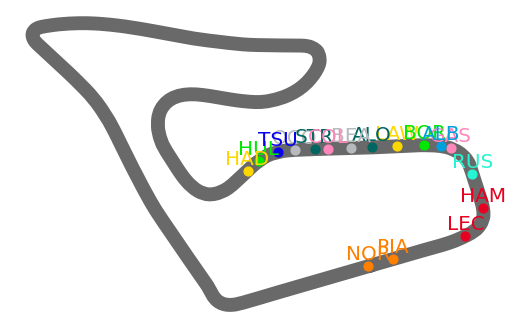

In [10]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()
circuit_info = session.get_circuit_info()

track = pos.loc[:, ('X', 'Y')].to_numpy()
track_angle = circuit_info.rotation / 180 * np.pi

rotated_track = rotate(track, angle=track_angle)

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

ax.plot(rotated_track[:, 0], rotated_track[:, 1], linewidth=10, color='dimgrey')
ax.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

ax.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)
each_lap = session.laps.pick_laps(range(0, Lap_Number))

first_driver_session_time_in_microsec = int(str((each_lap.LapStartTime[each_lap.Position == 1 & (each_lap.LapNumber == max(each_lap.LapNumber))].values/1000)[0]).split(' ')[0])

for driver in session.drivers:

    each_lap = session.laps.pick_laps(range(0, Lap_Number)).pick_drivers(driver)
    each_lap = each_lap[each_lap.Position == each_lap.Position]
    try:
        each_lap_data = each_lap.get_pos_data()
        
        each_lap_pos_data = each_lap_data.loc[:, ('X', 'Y')].to_numpy()
        each_lap_rotated_data = rotate(each_lap_pos_data, angle=track_angle)
        each_lap_data.loc[:, 'X'] = each_lap_rotated_data[:, 0]
        each_lap_data.loc[:, 'Y'] = each_lap_rotated_data[:, 1]
        
        txt = each_lap.Driver.iloc[0]

        pos_x = (each_lap_data['X'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])
        pos_y = (each_lap_data['Y'].iloc[(each_lap_data['SessionTime'] - timedelta(microseconds = first_driver_session_time_in_microsec)).abs().argsort()[:1]])

        ax.scatter(pos_x.iloc[0], pos_y.iloc[0], color=fastf1.plotting.get_driver_color(txt, session=session), s=40, zorder=2)
        ax.text(pos_x.iloc[0], pos_y.iloc[0]+400, txt, color=fastf1.plotting.get_driver_color(txt, session=session), 
                va='center_baseline', ha='center', size='x-large', zorder=3)
    except:
        continue


In [ ]:
end = time.time()

print(f"Total runtime of the program is {end - start} seconds")

Total runtime of the program is 6.136989116668701 seconds
